# Driver ranking benchmark

Notebook benchmarks driver ranking.

## Library import

In [ ]:
import pandas as pd
import scipy
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns

import cellrank as cr
import scanpy as sc
import scvelo as scv

from rgv_tools import DATA_DIR, FIG_DIR

## Constants

In [2]:
DATASET = "zebrafish"

In [40]:
SAVE_FIGURES = False
if SAVE_FIGURES:
    (FIG_DIR / DATASET).mkdir(parents=True, exist_ok=True)

In [ ]:
TERMINAL_STATES = [
    "mNC_head_mesenchymal",
    "mNC_arch2",
    "mNC_hox34",
    "Pigment",
]

## General setting

In [6]:
plt.rcParams["svg.fonttype"] = "none"
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params("scvelo", dpi_save=400, dpi=80, transparent=True, fontsize=14, color_map="viridis")

## Data loading

In [79]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_run_regvelo.h5ad")

## Driver ranking analysis

### Correlating gene expression with cell fate probabilities

In [ ]:
vk = cr.kernels.VelocityKernel(adata)
vk.compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()

kernel = 0.8 * vk + 0.2 * ck

100%|██████████| 697/697 [00:00<00:00, 1533.88cell/s]


100%|██████████| 4/4 [00:00<00:00, 87.88/s]


In [ ]:
estimator = cr.estimators.GPCCA(kernel)
## evaluate the fate prob on original space
estimator.compute_macrostates(n_states=8, cluster_key="cell_type")
estimator.set_terminal_states(TERMINAL_STATES)
estimator.compute_fate_probabilities()

In [ ]:
df = estimator.compute_lineage_drivers(cluster_key="cell_type")
fate_prob = pd.DataFrame(
    estimator.adata.obsm["lineages_fwd"], columns=estimator.adata.obsm["lineages_fwd"].names.tolist()
)

### Correlating gene activity with cell fate probabilities

In [82]:
GeneActivity = pd.read_csv(DATA_DIR / DATASET / "raw" / "GeneActivity.csv", index_col=0)

In [83]:
gene_symbol = [i.replace("_pos", "").replace("_neg", "") for i in GeneActivity.index.tolist()]
ind = [i in adata.var_names[adata.var["TF"]] for i in gene_symbol]
GeneActivity = GeneActivity.iloc[ind, :]
gene_symbol = [i.replace("_pos", "").replace("_neg", "") for i in GeneActivity.index.tolist()]


df_a = pd.DataFrame(columns=df.columns.tolist())
for i in fate_prob.columns.tolist():
    cor = []
    pval = []
    for g in GeneActivity.index.tolist():
        res = scipy.stats.pearsonr(GeneActivity.loc[g, :], fate_prob.loc[:, i])
        cor.append(res[0])
        pval.append(res[1])
    df_a[i + "_corr"] = cor
    df_a[i + "_pval"] = pval
df_a.index = GeneActivity.index.tolist()

## Predict known drivers

In [84]:
driver_head_mes = ["nr2f5", "nr2f2", "sox9b", "twist1a", "twist1b"]
driver_pigment = ["sox10", "mitfa", "tfec", "bhlhe40", "tfap2b", "tfap2a"]

#### mNC head mesenchymal

In [85]:
score_head_mes = []
label_ga = [1 if i in driver_head_mes else 0 for i in df_a.index.tolist()]
label_gex = [1 if i in driver_head_mes else 0 for i in df.index.tolist()]

In [86]:
for nrun in range(3):
    coef_name = "coef_" + str(nrun)
    coef = pd.read_csv(DATA_DIR / DATASET / "results" / coef_name, index_col=0)

    label_rgv = [1 if i in driver_head_mes else 0 for i in coef.index.tolist()]
    score_head_mes.append(roc_auc_score(label_rgv, coef["mNC_head_mesenchymal"]))

score_head_mes.append(roc_auc_score(label_ga, df_a["mNC_head_mesenchymal_corr"]))
score_head_mes.append(roc_auc_score(label_gex, df["mNC_head_mesenchymal_corr"]))

#### Pigment

In [87]:
score_pigment = []

for nrun in range(3):
    coef_name = "coef_" + str(nrun)
    coef = pd.read_csv(DATA_DIR / DATASET / "results" / coef_name, index_col=0)

    label_rgv = [1 if i in driver_pigment else 0 for i in coef.index.tolist()]
    score_pigment.append(roc_auc_score(label_rgv, coef["Pigment"]))

label_ga = [1 if i in driver_pigment else 0 for i in df_a.index.tolist()]
label_gex = [1 if i in driver_pigment else 0 for i in df.index.tolist()]
score_pigment.append(roc_auc_score(label_ga, df_a["Pigment_corr"]))
score_pigment.append(roc_auc_score(label_gex, df["Pigment_corr"]))

## Plot results

In [ ]:
dat = pd.DataFrame({"AUROC": score_head_mes, "method": ["RegVelo (PS)"] * 3 + ["CR (GA)"] + ["CR (GEX)"]})
dat2 = pd.DataFrame({"AUROC": score_pigment, "method": ["RegVelo (PS)"] * 3 + ["CR (GA)"] + ["CR (GEX)"]})
dat["Lineage"] = "mNC head mesenchymal"
dat2["Lineage"] = "Pigment"
df = pd.concat([dat, dat2], axis=0)

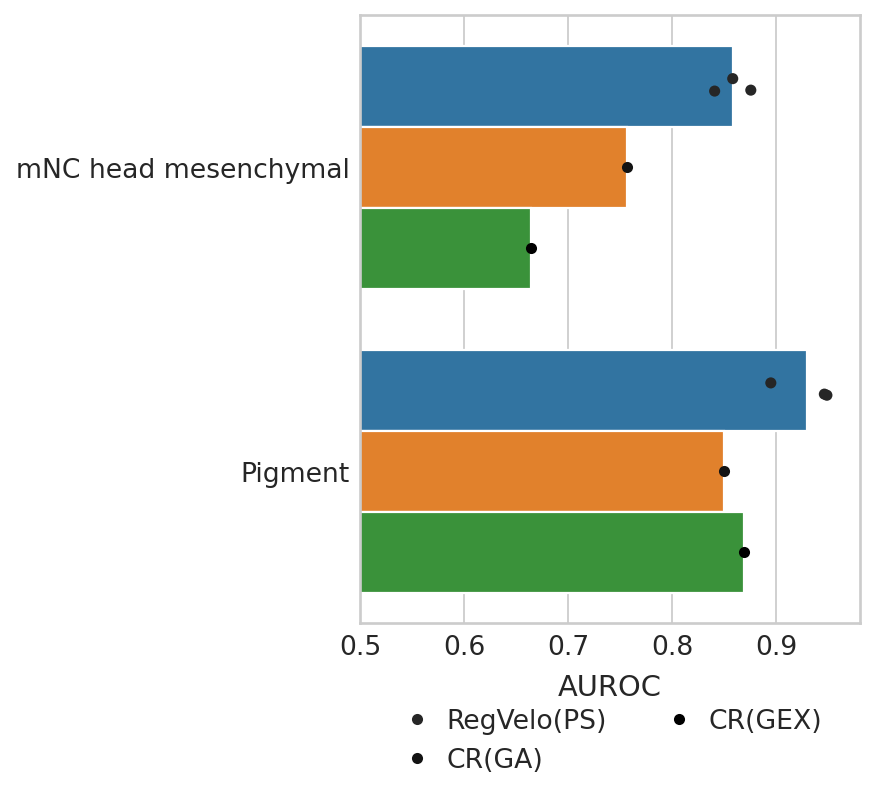

In [89]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(4, 5))

    # Plot the barplot without error bars
    sns.barplot(data=df, y="Lineage", x="AUROC", hue="method", ax=ax, ci=None)

    # Add jittered dots
    sns.stripplot(data=df, y="Lineage", x="AUROC", hue="method", dodge=True, color="black", ax=ax, jitter=True)

    # Remove the duplicate legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[3:6], labels[3:6], bbox_to_anchor=(0.5, -0.1), loc="upper center", ncol=2)

    # Customize labels and other settings
    ax.set(ylabel="", xlabel="AUROC")
    ax.set_xlabel(xlabel="AUROC", fontsize=13)
    ax.set_xlim(0.5, 0.98)

    if SAVE_FIGURES:
        plt.savefig(FIG_DIR / DATASET / "AUROC_ranking.svg", format="svg", transparent=True, bbox_inches="tight")
    plt.show()